In [1]:
# Need to install EGG since we are on google collab
!pip install git+https://github.com/facebookresearch/EGG.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/EGG.git to /tmp/pip-req-build-xbs0vwu7
  Running command git clone -q https://github.com/facebookresearch/EGG.git /tmp/pip-req-build-xbs0vwu7
     |████████████████████████████████| 235 kB 4.8 MB/s 
     |████████████████████████████████| 1.8 MB 53.4 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
     |████████████████████████████████| 153 kB 56.6 MB/s 
     |████████████████████████████████| 181 kB 58.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for EGG: filename=EGG-0.1.0-py3-none-any.whl size=170091 sha256=75ea92d1813c1dbdcd5285fff69994fd9c9b34a2cfe6cb8e4881453386cfe9d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-i2ba7zjc/wheels/59/f6/b1/35178f81af5f19f8e5e1d68b9dec9a866abea93cccd7ba722e
  Created wheel for pathtools: filename=pat

In [5]:
from typing import List, Tuple, Optional, overload

import torch
from torch import nn
# from torch.parameter import Parameter
from torch.nn import functional as F
import egg.core as core
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

# For convenince and reproducibility, we set some EGG-level command line arguments here
opts = core.init(params=['--random_seed=7', # will initialize numpy, torch, and python RNGs
                         '--lr=1e-3',   # sets the learning rate for the selected optimizer 
                         '--batch_size=32',
                         '--optimizer=adam'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


batch_size = opts.batch_size # set via the CL arguments above

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(
            './data', 
            train=True, 
            download=True,
           transform=ToTensor()
        ),
        batch_size=batch_size, 
        shuffle=True, 
        # **kwargs
    )
test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(
            './data', 
            train=False, 
            transform=ToTensor()
        ),
        batch_size=batch_size, 
        shuffle=False, 
        # **kwargs
    )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [59]:
# Commented these out, since we might just implement our own vision modules
# vision_module = models.resnet18(pretrained=True)
# vision_module.eval()
# vision_module.to(device)


# TODO: adjust the dimensions of the vectors, so they are actually usefull for 
# cifar10 (these were the ones used for MNIST)

OUTPUT_SIZE_OF_VISION = 500
IN_FEATURES = 4*4*50
class Vision(nn.Module):
    def __init__(self):
        super(Vision, self).__init__()
        #           self.conv1 = nn.Conv2d(1, 20, 5, 1)
        #           self.conv2 = nn.Conv2d(20, 50, 5, 1)
        # [20, 1, 5, 5], expected input[32, 3, 32, 32]
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(IN_FEATURES, OUTPUT_SIZE_OF_VISION)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, IN_FEATURES)
        x = F.relu(self.fc1(x))
        return x

class PretrainNet(nn.Module):
    def __init__(self, vision_module):
        super(PretrainNet, self).__init__()
        self.vision_module = vision_module
        self.fc = nn.Linear(OUTPUT_SIZE_OF_VISION, 10)
        
    def forward(self, x):
        x = self.vision_module(x)
        # x = self.fc(F.relu(x))
        x = self.fc(F.leaky_relu(x))
        return x


In [60]:
# Now, everything is ready to actually run the pre-training. 
# First, we instantiate the modules and then run 10 epochs 
# of MNIST digit recognition by a PretrainNet instance:


vision = Vision()
class_prediction = PretrainNet(vision) #  note that we pass vision - which we want to pretrain
optimizer = core.build_optimizer(class_prediction.parameters()) #  uses command-line parameters we passed to core.init
class_prediction = class_prediction.to(device)

# Here we want to pretrain or vision

for epoch in range(10):
    mean_loss, n_batches = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = class_prediction(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        mean_loss += loss.mean().item()
        n_batches += 1
        
    print(f'Train Epoch: {epoch}, mean loss: {mean_loss / n_batches}')



Train Epoch: 0, mean loss: 1.5615529068295801
Train Epoch: 1, mean loss: 1.2901345278617289
Train Epoch: 2, mean loss: 1.1791282770577258
Train Epoch: 3, mean loss: 1.089407560006213
Train Epoch: 4, mean loss: 1.0142730458455442
Train Epoch: 5, mean loss: 0.9504274089826046
Train Epoch: 6, mean loss: 0.8909423596303736
Train Epoch: 7, mean loss: 0.8300171162902127
Train Epoch: 8, mean loss: 0.7734993977075346
Train Epoch: 9, mean loss: 0.7184187559385904


In [61]:
# base class to copy from for both agents, using RNNBase and LSTM as reference
# from pytorch's official docs
# class ProjectLSTM(nn.Module):
#     input_size: int
#     hidden_size: int
#     num_layers: int
#     bias: bool
#     batch_first: bool
#     dropout: float
#     bidirectional: bool
#     proj_size: int
#     def __init__(
#         self, 
#         input_size: int, 
#         hidden_size: int, 
#         num_layers: int = 1, 
#         bias: bool = True, 
#         batch_first: bool = False,
#         dropout: float = 0, 
#         # bidirectional: bool = False, 
#         proj_size: int = 0,
#     ) -> None:
#         super(RNNBase, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.bias = bias
#         self.batch_first = batch_first
#         self.dropout = float(dropout)
#         # self.bidirectional = bidirectional
#         self.proj_size = proj_size
#         # num_directions = 2 if bidirectional else 1
#         if proj_size < 0:
#             raise ValueError("proj_size should be a positive integer or zero to disable projections")
#         if proj_size >= hidden_size:
#             raise ValueError("proj_size has to be smaller than hidden_size")
#         # This would normally be set by the "mode"
#         gate_size = 4 * hidden_size
#         self._flat_weights_names = []
#         self._all_weights = []
#         for layer in range(num_layers):
#             real_hidden_size = proj_size if proj_size > 0 else hidden_size
#             layer_input_size = input_size 

#             w_ih = Parameter(
#                 torch.empty(
#                     (gate_size,layer_input_size), 
#                     # **factory_kwargs
#                 )
#             )
#             w_hh = Parameter(
#                 torch.empty(
#                     (gate_size, real_hidden_size), 
#                     # **factory_kwargs
#                 )
#             )
#             b_ih = Parameter(
#                 torch.empty(
#                     gate_size, 
#                     # **factory_kwargs
#                 )
#             )
#             # Second bias vector included for CuDNN compatibility. Only one
#             # bias vector is needed in standard definition.
#             b_hh = Parameter(
#                 torch.empty(
#                     gate_size, 
#                     # **factory_kwargs
#                 )
#             )
#             # A touple of tensors
#             layer_params = ()
#             if self.proj_size == 0:
#                 if bias:
#                     layer_params = (w_ih, w_hh, b_ih, b_hh)
#                 else:
#                     layer_params = (w_ih, w_hh)
#             else:
#                 w_hr = Parameter(
#                     torch.empty(
#                         (proj_size, hidden_size), 
#                         # **factory_kwargs
#                     )
#                 )
#                 if bias:
#                     layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
#                 else:
#                     layer_params = (w_ih, w_hh, w_hr)

#             suffix = ''
#             param_names = ['weight_ih_l{}{}', 'weight_hh_l{}{}']
#             if bias:
#                 param_names += ['bias_ih_l{}{}', 'bias_hh_l{}{}']
#             if self.proj_size > 0:
#                 param_names += ['weight_hr_l{}{}']
#             param_names = [x.format(layer, suffix) for x in param_names]

#             for name, param in zip(param_names, layer_params):
#                 setattr(self, name, param)
#             self._flat_weights_names.extend(param_names)
#             self._all_weights.append(param_names)

#         self._flat_weights = [(lambda wn: getattr(self, wn) if hasattr(self, wn) else None)(wn) for wn in self._flat_weights_names]
#         # Don't really know whether we need these. Maybe it's just for
#         # optimization
#         # self.flatten_parameters()

#         # self.reset_parameters()


#         # self.reset_parameters()
#     def get_expected_cell_size(self, input: Tensor, batch_sizes: Optional[Tensor]) -> Tuple[int, int, int]:
#         if batch_sizes is not None:
#             mini_batch = int(batch_sizes[0])
#         else:
#             mini_batch = input.size(0) if self.batch_first else input.size(1)
#         num_directions = 2 if self.bidirectional else 1
#         expected_hidden_size = (self.num_layers * num_directions,
#                                 mini_batch, self.hidden_size)
#         return expected_hidden_size

#     # In the future, we should prevent mypy from applying contravariance rules here.
#     # See torch/nn/modules/module.py::_forward_unimplemented
#     def check_forward_args(self,  # type: ignore[override]
#                            input: Tensor,
#                            hidden: Tuple[Tensor, Tensor],
#                            batch_sizes: Optional[Tensor],
#                            ):
#         self.check_input(input, batch_sizes)
#         self.check_hidden_size(hidden[0], self.get_expected_hidden_size(input, batch_sizes),
#                                'Expected hidden[0] size {}, got {}')
#         self.check_hidden_size(hidden[1], self.get_expected_cell_size(input, batch_sizes),
#                                'Expected hidden[1] size {}, got {}')

#     # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
#     def permute_hidden(self,  # type: ignore[override]
#                        hx: Tuple[Tensor, Tensor],
#                        permutation: Optional[Tensor]
#                        ) -> Tuple[Tensor, Tensor]:
#         if permutation is None:
#             return hx
#         return apply_permutation(hx[0], permutation), apply_permutation(hx[1], permutation)


#     def forward(self, input, hx=None):  # noqa: F811
#         # orig_input = input
#         # xxx: isinstance check needs to be in conditional for TorchScript to compile
#         # batch_sizes = None
#         # if isinstance(orig_input, PackedSequence):
#         #     input, batch_sizes, sorted_indices, unsorted_indices = input
#         #     max_batch_size = batch_sizes[0]
#         #     max_batch_size = int(max_batch_size)
#         # else:
#         batch_sizes = None
#         is_batched = input.dim() == 3
#         batch_dim = 0 if self.batch_first else 1
#         if not is_batched:
#             input = input.unsqueeze(batch_dim)
#         max_batch_size = input.size(0) if self.batch_first else input.size(1)
#         sorted_indices = None
#         unsorted_indices = None

#         if hx is None:
#             num_directions = 2 if self.bidirectional else 1
#             real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
#             h_zeros = torch.zeros(self.num_layers * num_directions,
#                                   max_batch_size, real_hidden_size,
#                                   dtype=input.dtype, device=input.device)
#             c_zeros = torch.zeros(self.num_layers * num_directions,
#                                   max_batch_size, self.hidden_size,
#                                   dtype=input.dtype, device=input.device)
#             hx = (h_zeros, c_zeros)
#         else:
#             if batch_sizes is None:  # If not PackedSequence input.
#                 if is_batched:
#                     if (hx[0].dim() != 3 or hx[1].dim() != 3):
#                         msg = ("For batched 3-D input, hx and cx should "
#                                f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors")
#                         raise RuntimeError(msg)
#                 else:
#                     if hx[0].dim() != 2 or hx[1].dim() != 2:
#                         msg = ("For unbatched 2-D input, hx and cx should "
#                                f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors")
#                         raise RuntimeError(msg)
#                     hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))

#             # Each batch of the hidden state should match the input sequence that
#             # the user believes he/she is passing in.
#             hx = self.permute_hidden(hx, sorted_indices)

#         self.check_forward_args(input, hx, batch_sizes)
#         if batch_sizes is None:
#             result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
#                               self.dropout, self.training, self.bidirectional, self.batch_first)
#         else:
#             result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,
#                               self.num_layers, self.dropout, self.training, self.bidirectional)
#         output = result[0]
#         hidden = result[1:]
#         # xxx: isinstance check needs to be in conditional for TorchScript to compile
#         if isinstance(orig_input, PackedSequence):
#             output_packed = PackedSequence(output, batch_sizes, sorted_indices, unsorted_indices)
#             return output_packed, self.permute_hidden(hidden, unsorted_indices)
#         else:
#             if not is_batched:
#                 output = output.squeeze(batch_dim)
#                 hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
#             return output, self.permute_hidden(hidden, unsorted_indices)



class Sender(nn.Module):
    def __init__(self, vision, output_size):
        super(Sender, self).__init__()
        self.fc = nn.Linear(OUTPUT_SIZE_OF_VISION , output_size)
        self.vision = vision
        
    def forward(self, x, aux_input=None):
        with torch.no_grad():
            x = self.vision(x)
        x = self.fc(x)
        return x
    
# Flattened dimensions of  dataset input (MNIST = 28 x 28 x 1 = 784)
# 32 * 32 * 3
OUTPUT_DIMENSIONS_FROM_SENDER = 3072
class Receiver(nn.Module):
    def __init__(self, input_size):
        super(Receiver, self).__init__()
        self.fc = nn.Linear(input_size, OUTPUT_DIMENSIONS_FROM_SENDER)

    def forward(self, channel_input, receiver_input=None, aux_input=None):
        x = self.fc(channel_input)
        return torch.sigmoid(x)

sender = Sender(vision, output_size=400)
receiver = Receiver(input_size=400)


In [62]:
vocab_size = 10

def loss(sender_input, _message, _receiver_input, receiver_output, _labels, _aux_input=None):
    loss = F.binary_cross_entropy(receiver_output, sender_input.view(-1, OUTPUT_DIMENSIONS_FROM_SENDER), reduction='none').mean(dim=1)
    return loss, {}


sender = Sender(vision, vocab_size)
sender = core.GumbelSoftmaxWrapper(sender, temperature=1.0) # wrapping into a GS interface, requires GS temperature
receiver = Receiver(input_size=400)
receiver = core.SymbolReceiverWrapper(receiver, vocab_size, agent_input_size=400)

In [63]:
game = core.SymbolGameGS(sender, receiver, loss)
optimizer = torch.optim.Adam(game.parameters())

trainer = core.Trainer(
    game=game, optimizer=optimizer, train_data=train_loader,
    validation_data=test_loader, callbacks=[core.TemperatureUpdater(agent=sender, decay=0.9, minimum=0.1)]
)


# sender = Sender(vision, hidden_size)
# receiver = Receiver(hidden_size)

# sender_rnn = core.RnnSenderGS(sender, vocab_size, emb_size, hidden_size, cell="gru", max_len=2, temperature=1.0)
# receiver_rnn = core.RnnReceiverGS(receiver, vocab_size, emb_size, hidden_size, cell="gru")

In [64]:
# def loss(sender_input, _message, _receiver_input, receiver_output, _labels, _aux_input=None):
#     loss = F.binary_cross_entropy(receiver_output, sender_input.view(-1, 784), reduction='none').mean(dim=1)
    # return loss, {}


n_epochs = 15
trainer.train(n_epochs)



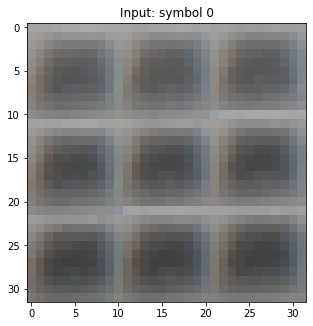

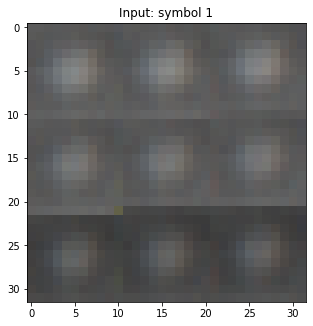

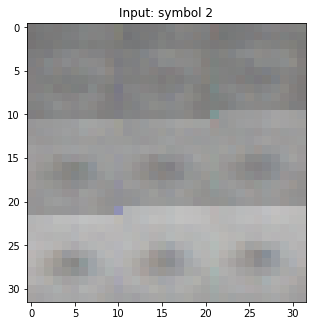

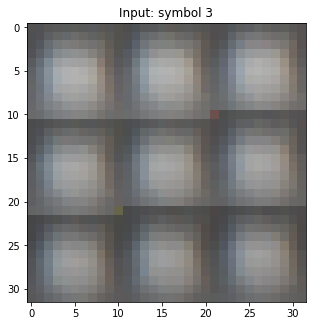

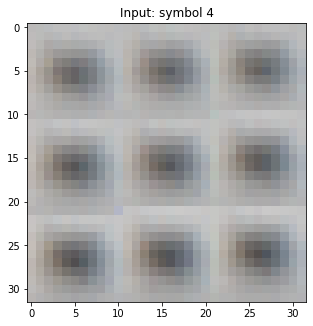

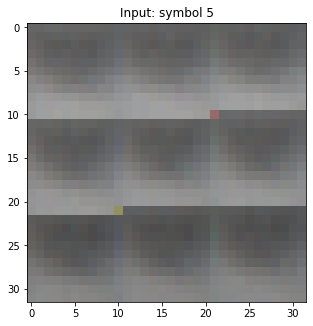

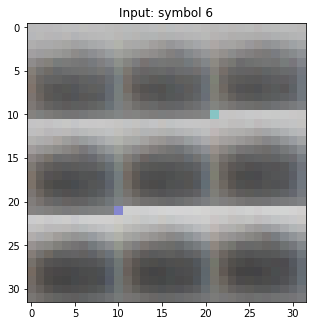

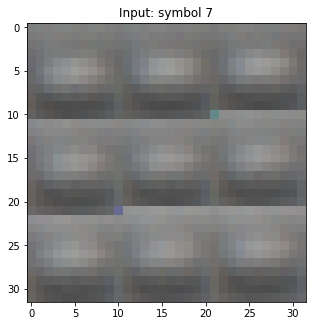

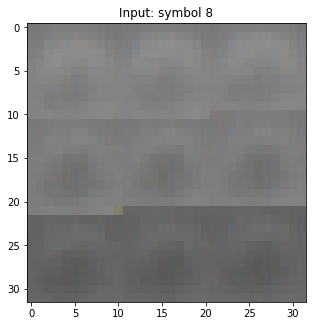

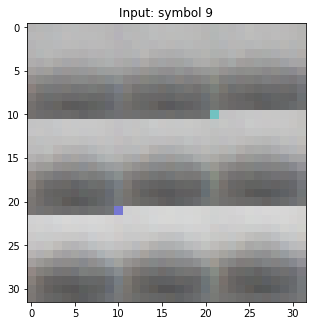

In [67]:
# def loss(_sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
#     acc = (receiver_output. == labels.argmax(dim=1)).detach().float()
#     loss = F.cross_entropy(receiver_output, labels, reduction="none")
#     return loss, {"acc": acc}
game.eval()

for z in range(vocab_size):
    t = torch.zeros(vocab_size).to(device)
    t[z] = 1
    with torch.no_grad():
        # Receiver outputs a single tensor of predictions
        sample = game.receiver(t).float().cpu()
    sample = sample.view(32, 32, 3)
    plt.title(f"Input: symbol {z}")
    plt.imshow(sample, cmap='gray')
    plt.show()